In [80]:
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from natsort import natsorted
from pydicom import dcmread
from ultralytics import YOLO

In [81]:
os.makedirs('train',exist_ok=True)

In [20]:
def load_data_dcm(path_num,path_all = False):
    path = path_num
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)
    temp_img = dcmread(path+pic_paths[0]).pixel_array
    imgs_from_folder = np.zeros((len(pic_paths),*temp_img.shape))
    for i,j in enumerate(pic_paths):
        aa = dcmread(path+j)
        imgs_from_folder[i] = aa.pixel_array
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

def load_data(dirname, scan_num):
    path = f'{dirname}/{scan_num}/'
    # path = 'intervolume_registered/self_inter/scan5/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.h5'):
            pic_paths.append(i)
    with h5py.File(path+pic_paths[0], 'r') as hf:
        original_data = hf['volume'][:,100:-100,:]
    return original_data

In [82]:
data = load_data('/Users/akapatil/Documents/OCT/Bifocal registration/Patrice_5_2_2025/batch1_endo',
                 'scan1')

# data = load_data_dcm('/Users/akapatil/Documents/OCT/Bifocal registration/pic3_Healthy_8192/data/')
# data = data[:,np.r_[200:600,1500:2200]]

In [83]:
temp_transposed_data = np.transpose(data,(2,1,0))

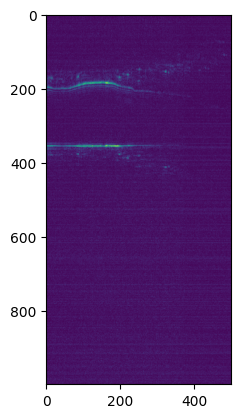

In [84]:
plt.imshow(temp_transposed_data[100])

In [45]:
n = len(os.listdir('train'))
for i in tqdm(range(0,data.shape[0],10)):
    cv2.imwrite(f'train/'+f'frame{n+1}.PNG',data[i])
    n+=1

100%|██████████| 50/50 [00:00<00:00, 225.46it/s]


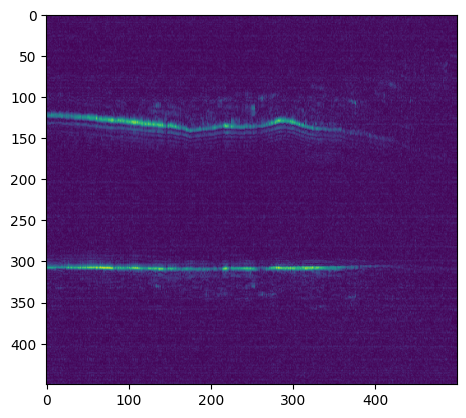

In [9]:
for i in (os.listdir('/Users/akapatil/Documents/feature_extraction/sample_data/labels/train')):
    print(i.removesuffix('.txt'))

frame126
frame132
frame133
frame127
frame119
frame131
frame125
frame124
frame130
frame118
frame120
frame108
frame109
frame121
frame135
frame123
frame136
frame122
frame145
frame151
frame150
frame144
frame152
frame146
frame147
frame153
frame157
frame143
frame142
frame156
frame140
frame154
frame168
frame169
frame155
frame141
frame158
frame164
frame170
frame171
frame165
frame159
frame167
frame166
frame172
frame162
frame163
frame161
frame149
frame148
frame160
frame11
frame107
frame113
frame112
frame106
frame10
frame138
frame12
frame110
frame104
frame105
frame111
frame139
frame13
frame115
frame101
frame129
frame17
frame16
frame128
frame100
frame114
frame102
frame116
frame1
frame14
frame15
frame117
frame103


In [15]:
# import os
# import shutil

# # Define paths
# labels_dir = "sample_data/data/labels/train"
# images_dir = "sample_data/data/images/train"

# # Get the list of frames mentioned in labels
# label_files = os.listdir(labels_dir)
# frames_to_keep = {os.path.splitext(label)[0] for label in label_files}

# # Iterate through images and remove those not in frames_to_keep
# for image_file in os.listdir(images_dir):
#     image_name, ext = os.path.splitext(image_file)
#     if image_name not in frames_to_keep:
#         image_path = os.path.join(images_dir, image_file)
#         os.remove(image_path)
#         print(f"Removed: {image_path}")


# print("Cleanup complete.")

In [22]:
import os
import random
import shutil

# Define paths
base_dir = "yolo_annots"
images_train_dir = os.path.join(base_dir, "images/train")
images_val_dir = os.path.join(base_dir, "images/val")
labels_train_dir = os.path.join(base_dir, "labels/train")
labels_val_dir = os.path.join(base_dir, "labels/val")

# Create val directories if they don't exist
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)

# Get all image files in the train directory
image_files = [f for f in os.listdir(images_train_dir) if f.lower().endswith(".png")]

# Randomly select 20% of the files
val_count = int(len(image_files) * 0.2)
val_files = random.sample(image_files, val_count)

# Move selected files to val directories
for image_file in val_files:
    # Move image file
    image_src = os.path.join(images_train_dir, image_file)
    image_dest = os.path.join(images_val_dir, image_file)
    shutil.move(image_src, image_dest)

    # Move corresponding label file
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_src = os.path.join(labels_train_dir, label_file)
    label_dest = os.path.join(labels_val_dir, label_file)
    if os.path.exists(label_src):  # Ensure label file exists
        shutil.move(label_src, label_dest)

print(f"Moved {val_count} image-label pairs to validation set.")

Moved 59 image-label pairs to validation set.


In [27]:
import os

# Define paths
images_val_dir = "/Users/akapatil/Documents/feature_extraction/yolo_annots/images/train/"
val_txt_path = "yolo_annots/train.txt"

# Get all image files in the val directory
val_paths = [
    os.path.join(images_val_dir, filename)
    for filename in os.listdir(images_val_dir)
    if filename.lower().endswith((".png", ".jpg"))
]

# Write the paths to Val.txt
with open(val_txt_path, "w") as file:
    file.write("\n".join(val_paths) + "\n")

print(f"Created {val_txt_path} with paths to validation images.")

Created yolo_annots/train.txt with paths to validation images.


In [43]:
model = YOLO("yolov12s_best.pt")

In [85]:
static_flat = np.argmax(np.sum(data[:,:,:],axis=(0,1)))
static_flat

np.int64(110)

In [86]:
temp_transposed_data[1].shape

(1000, 500)

In [87]:
test = (np.dstack([temp_transposed_data[static_flat]]*3))

In [88]:
test = (((test-test.min())/(test.max()-test.min()))*255).astype(np.uint8)

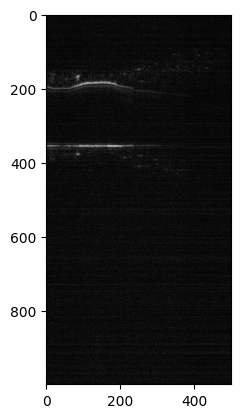

In [89]:
plt.imshow(test)

In [103]:
result = model.predict(np.ascontiguousarray(test),save=False,classes=1,iou=0.5)

In [104]:
result[0].summary()

[{'name': 'cells',
  'class': 1,
  'confidence': 0.58672,
  'box': {'x1': 0.0, 'y1': 366.668, 'x2': 500.0, 'y2': 442.46356}},
 {'name': 'cells',
  'class': 1,
  'confidence': 0.47705,
  'box': {'x1': 0.0, 'y1': 121.38288, 'x2': 500.0, 'y2': 179.6974}}]

In [91]:
result[0].summary()[0]['box']['y1']

366.668

In [61]:
result[0].numpy().boxes.xyxy[:,[1,3]].astype(int)

array([[ 51, 158]])

In [32]:
test.shape

(1000, 500, 3)

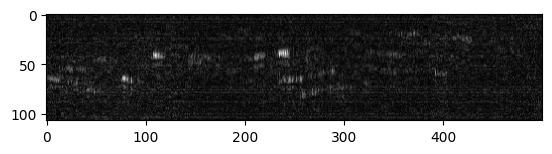

In [34]:
plt.imshow(test[51:158])